In [1]:
using StatsBase, HDF5, JLD, Test, ProgressMeter, Pkg

In [2]:
include("betaSkeletons.jl")

plotDelaunay (generic function with 1 method)

In [4]:
using LsqFit

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1192


## Inverse participation ratio

In [5]:
for (indx, qi) in enumerate(-4:0.1:4)
    if qi == 2
        println("The index for $qi is  $indx")
    end
end

The index for 2.0 is  61


In [ ]:
50, 20000, 100, 10000, 200, 5000, 400, 2500, 800, 1250, 1600, 625

In [6]:
function getdimsfilekey(filename, keyname)
    fileattr = h5open(filename,"r")
    dimensiones = size(readmmap(fileattr[keyname]))    
    close(fileattr)
    dimensiones
end

getdimsfilekey (generic function with 1 method)

In [7]:
dimsamples = getdimsfilekey("lDim50beta1.0.h5", "iprqss")
totalsamples = dimsamples[1]*dimsamples[3]

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5F.c line 370 in H5Fis_hdf5(): unable open file
    major: File accessibilty
    minor: Not an HDF5 file
  #001: H5Fint.c line 802 in H5F__is_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #002: H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = 'lDim50beta1.0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file lDim50beta1.0.h5

In [9]:
suma = sum(h5read("lDim50beta1.0.h5", "iprqss", (:,61,:)))

133630.017056112

In [10]:
aviprqi = sum(h5read("lDim50beta1.0.h5", "iprqss", (:,61,:)))/totalsamples

0.267260034112224

In [17]:
sum(log10.(h5read("lDim50beta1.0.h5", "iprqss", (:,61,:))))/totalsamples

-0.6616980810271091

In [11]:
numpoints = [50,100,200,400, 500, 800, 1000, 2000, 1600, 3200, 4000];

In [26]:
valuesIPR = []
for sdim in numpoints
    dimsamples = getdimsfilekey("lDim$(sdim)beta1.0.h5", "iprqss")
    totalsamples = dimsamples[1]*dimsamples[3]
     push!(valuesIPR, sum(h5read("lDim$(sdim)beta1.0.h5", "iprqss", (:,61,:)))/totalsamples)
end

In [36]:
valuesIPRlog = []
for sdim in numpoints
    dimsamples = getdimsfilekey("lDim$(sdim)beta1.0.h5", "iprqss")
    totalsamples = dimsamples[1]*dimsamples[3]
     push!(valuesIPRlog, sum(log.(h5read("lDim$(sdim)beta1.0.h5", "iprqss", (:,61,:))))/totalsamples)
end

In [37]:
valuesIPRlog

11-element Array{Any,1}:
 -1.5236161374357877
 -1.7305170280911069
 -1.9090531786310483
 -2.0598154777202304
 -2.097201549338743 
 -2.1740920273972706
 -2.207553791730864 
 -2.2910509137246726
 -2.267055257664353 
 -2.3320610213543715
 -2.350615321643743 

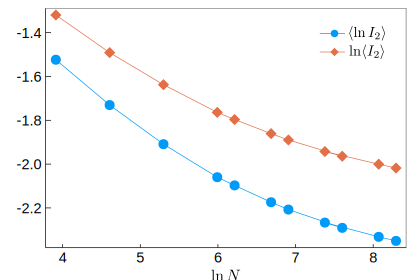

In [58]:
plot(log.(numpoints), valuesIPRlog, m = (8, stroke(0)),
    legend = true, grid = false, axis = :on, framestyle=:box, legendfontsize = 14, fg_legend = :white,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"\ln N", label = L"\langle \ln I_2\rangle", guidefont= font(15, "sans-serif"),
    dpi=70, size = (600,400))
plot!(log.(numpoints), log.(valuesIPR),  label = L"\ln \langle I_2\rangle", m = (8, :diamond, stroke(0)))
#savefig("I2comparacion.pdf")

### Let's fit a linear model 

In [483]:
linearmodel(x, m) = m[2]*x .+ m[1]

linearmodel (generic function with 1 method)

We will fit all values first, and second just the ones on the tail.

In [515]:
fitAll = curve_fit(linearmodel, log.(numpoints[1:end]), Float64.(valuesIPR[1:end]), [0.5,0.1])
fittail = curve_fit(linearmodel, log.(numpoints[5:end]), Float64.(valuesIPR)[5:end], [0.5,0.1]);

In [516]:
sigma_all = standard_error(fitAll)
sigma_tail = standard_error(fittail)
covar = estimate_covar(fitAll)
covartail = estimate_covar(fittail)
sigmaT = sqrt.(sigma_all[1].^2 .+ x_all.^2*sigma_all[2].^2 .+ 2*x_all*covar[2,1])
sigmaTail = sqrt.(sigma_tail[1].^2 .+ x_tail.^2*sigma_tail[2].^2 .+ 2*x_tail*covartail[2,1])
x_all = LinRange(3.5, 8.7, 50)
x_tail = LinRange(5.0, 8.7, 50);

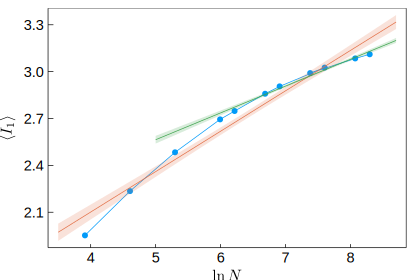

In [530]:
plot(log.(numpoints), Float64.(valuesIPR), m = (5, stroke(0)),
    legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"\ln N", ylab = L"\langle I_1\rangle", guidefont= font(15, "sans-serif"),
    dpi=70, size = (600,400))
plot!(x_all, linearmodel(x_all, fitAll.param), ribbon=(sigmaT, sigmaT), fillalpha=0.2)
plot!(x_tail, linearmodel(x_tail, fittail.param), ribbon=(sigmaTail, sigmaTail), fillalpha=0.2)
#savefig("iprq1.pdf")
#plot!(x_all, linearmodel(x_all, fitAll.param) .+ sigmaT)
#plot!(x_all, linearmodel(x_all, fitAll.param) .- sigmaT)

In [531]:
fitAll.param

2-element Array{Float64,1}:
 1.066014028505812 
 0.2587972592838944

In [532]:
fittail.param

2-element Array{Float64,1}:
 1.7053199148299167 
 0.17179270177872463

In [533]:
sigma_all

2-element Array{Float64,1}:
 0.11254676302110819 
 0.017079658160927574

In [534]:
sigma_tail

2-element Array{Float64,1}:
 0.07545091883426483 
 0.010279020168278984

In [535]:
covar

2×2 Array{Float64,2}:
  0.0126668   -0.00188176 
 -0.00188176   0.000291715

In [536]:
covartail

2×2 Array{Float64,2}:
  0.00569284   -0.000772069
 -0.000772069   0.000105658

In [537]:
valuesIPR = []
for sdim in numpoints
    dimsamples = getdimsfilekey("lDim$(sdim)beta1.0.h5", "iprqss")
    totalsamples = dimsamples[1]*dimsamples[3]
     push!(valuesIPR, sum(h5read("lDim$(sdim)beta1.0.h5", "iprqss", (:,61,:)))/totalsamples)
end

In [538]:
fitAll = curve_fit(linearmodel, log.(numpoints[1:end]), log.(valuesIPR[1:end]), [0.5,0.1])
fittail = curve_fit(linearmodel, log.(numpoints[5:end]), log.(valuesIPR)[5:end], [0.5,0.1]);

In [539]:
sigma_all = standard_error(fitAll)
sigma_tail = standard_error(fittail)
covar = estimate_covar(fitAll)
covartail = estimate_covar(fittail)
sigmaT = sqrt.(sigma_all[1].^2 .+ x_all.^2*sigma_all[2].^2 .+ 2*x_all*covar[2,1])
sigmaTail = sqrt.(sigma_tail[1].^2 .+ x_tail.^2*sigma_tail[2].^2 .+ 2*x_tail*covartail[2,1])
x_all = LinRange(3.5, 8.7, 50)
x_tail = LinRange(5.0, 8.7, 50);

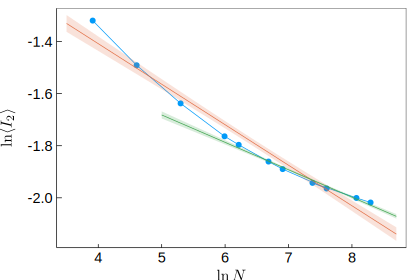

In [542]:
plot(log.(numpoints), log.(valuesIPR), m = (5, stroke(0)),
    legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"\ln N", ylab = L"\ln \langle I_2\rangle", guidefont= font(15, "sans-serif"),
    dpi=70, size = (600,400))
plot!(x_all, linearmodel(x_all, fitAll.param), ribbon=(sigmaT, sigmaT), fillalpha=0.2)
plot!(x_tail, linearmodel(x_tail, fittail.param), ribbon=(sigmaTail, sigmaTail), fillalpha=0.2)
#savefig("iprq2.pdf")

In [543]:
fitAll.param

2-element Array{Float64,1}:
 -0.7860595278474336 
 -0.15555539188824494

In [544]:
fittail.param

2-element Array{Float64,1}:
 -1.155634295298657  
 -0.10524035407831539

In [545]:
sigma_all

2-element Array{Float64,1}:
 0.06557585676341902 
 0.009951536473092484

In [546]:
covar

2×2 Array{Float64,2}:
  0.00430019   -0.000638831
 -0.000638831   9.90331e-5 

In [547]:
sigma_tail

2-element Array{Float64,1}:
 0.04155928850864705 
 0.005661809973447106

In [548]:
covartail

2×2 Array{Float64,2}:
  0.00172717   -0.000234241
 -0.000234241   3.20561e-5 

In [56]:
valuesIPRall = zeros(11,41)
for (indxq, q_val) in enumerate(41:81)
    for (indx, sdim) in enumerate(numpoints)
        dimsamples = getdimsfilekey("lDim$(sdim)beta1.0.h5", "iprqss")
        totalsamples = dimsamples[1]*dimsamples[3]
        valuesIPRall[indx,indxq] = sum(h5read("lDim$(sdim)beta1.0.h5", "iprqss", (:,q_val,:)))/totalsamples
    end
end

In [57]:
valuesIPRall

11×41 Array{Float64,2}:
   50.0   24.3076   13.3976   8.11655  …  0.0931339  0.0896403  0.0863894
  100.0   42.2689   20.7886  11.4736      0.0705169  0.0676392  0.064972 
  200.0   72.3154   31.5157  15.8244      0.0558559  0.0534304  0.0511894
  400.0  120.766    46.2161  21.0998      0.0454679  0.0433816  0.0414594
  500.0  141.2      51.6481  22.8629      0.0430417  0.0410377  0.0391928
  800.0  195.111    64.8651  26.9458   …  0.0388716  0.0370181  0.0353142
 1000.0  225.606    71.5616  28.876       0.0370985  0.0353124  0.0336715
 2000.0  343.876    93.8719  34.756       0.0325645  0.0309301  0.0294312
 1600.0  301.368    86.366   32.8545      0.0338346  0.0321554  0.0306145
 3200.0  440.467   108.405   38.1456      0.0307291  0.0291685  0.0277384
 4000.0  491.32    115.362   39.7291   …  0.0297237  0.0281968  0.0267983

In [69]:
h5write("valuesIPRgeq0.h5", "valsgeq0", valuesIPRall) 

In [80]:
p=plot(legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
for i in 1:18
    plot!(log.(numpoints), log.(valuesIPRall[:,i]), seriestype = [:line, :scatter])
end

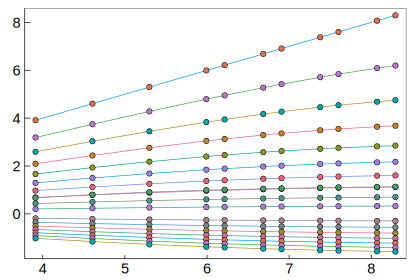

In [81]:
p

In [82]:
p=plot(legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
for i in 18:41
    plot!(log.(numpoints), log.(valuesIPRall[:,i]), seriestype = [:line, :scatter])
end

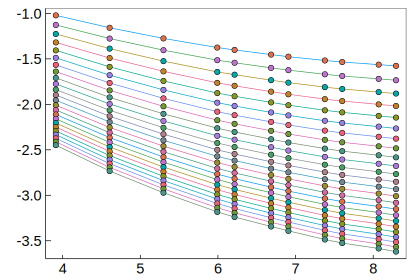

In [83]:
p

In [87]:
p=plot(legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
for i in 30:41
    plot!(numpoints, valuesIPRall[:,i], seriestype = [:line, :scatter])
end

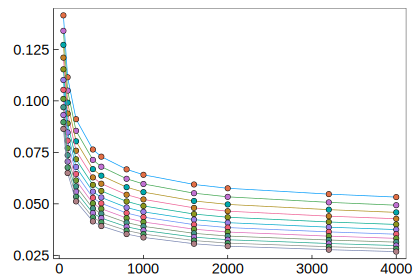

In [88]:
p

In [446]:
slopes = zeros(41)
sigmas = zeros(41)
for (indx, i) in enumerate(1:41)
    if i == 11
        fittails = curve_fit(linearmodel, log.(numpoints[5:end]), Float64.(valuesIPRall[:,i][5:end]), [0.5,0.1])
        slopes[indx] = fittails.param[2]
        sigmas[indx] =  standard_error(fittails)[2]
    else
        fittails = curve_fit(linearmodel, log.(numpoints[5:end]),log.(valuesIPRall[:,i][5:end]), [0.5,0.1])
        slopes[indx] = fittails.param[2]
        sigmas[indx] =  standard_error(fittails)[2]
    end
end

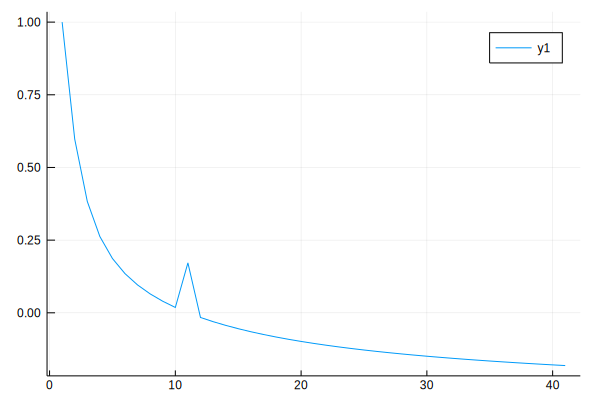

In [447]:
plot(slopes)

In [448]:
slopes[11]

0.17179270177872463

In [107]:
for (indx, qi) in enumerate(-4:0.1:4)
    if qi == 0
        println("The index for $qi is  $indx")
    end
end

The index for 0.0 is  41


In [449]:
alphaq = 1.0./(1 .- collect(0:0.1:4));

In [450]:
Dq = alphaq.*slopes;

In [451]:
findall(isinf.(Dq))

1-element Array{Int64,1}:
 11

In [452]:
Dq[findall(isinf.(Dq))] .= slopes[11]

1-element view(::Array{Float64,1}, [11]) with eltype Float64:
 0.17179270177872463

In [454]:
sigmas[1:2]

2-element Array{Float64,1}:
 6.033430877630299e-15
 0.015617170837403221 

In [458]:
sigma_err = sqrt.(sigmas.^2.0.*alphaq.^2);

In [459]:
sigma_err[11] = sigmas[11]

0.010279020168278984

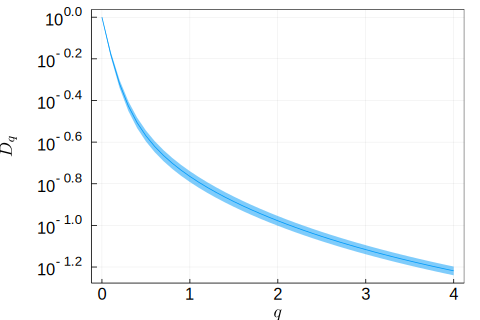

In [464]:
plot(collect(0:0.1:4), Dq, yscale =:log10, ribbon = (sigma_err, sigma_err),
    legend = false, grid = true, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"q", ylab = L"D_q", guidefont= font(15, "sans-serif"),
    dpi=80, size = (600,400))

In [ ]:
## Falta del 1 al 40. 

In [319]:
valuesIPRneg = zeros(11,40)
for (indxq, q_val) in enumerate(1:40)
    for (indx, sdim) in enumerate(numpoints)
        dimsamples = getdimsfilekey("lDim$(sdim)beta1.0.h5", "iprqss")
        totalsamples = dimsamples[1]*dimsamples[3]
        valuesIPRneg[indx,indxq] = sum(h5read("lDim$(sdim)beta1.0.h5", "iprqss", (:,q_val,:)))/totalsamples
    end
end

In [320]:
valuesIPRneg

11×40 Array{Float64,2}:
 3.38424e90   1.34759e88   5.36703e85   …     389.741        122.368
 6.64198e88   2.87916e86   1.24806e84        1128.38         290.278
 5.77007e93   1.88741e91   6.17511e88        3560.81         710.135
 2.95909e103  5.52882e100  1.03323e98       12722.8         1820.98 
 2.99173e105  5.0155e102   8.41233e99       19980.0         2506.9  
 1.35035e112  1.53129e109  1.7367e106   …   54283.9         4998.07 
 7.84174e116  6.76352e113  5.83476e110      92307.3         7076.42 
 9.21997e141  1.87559e138  3.81544e134     592306.0        22523.9  
 7.53319e136  2.0539e133   5.59992e129     314627.0        15342.5  
 1.1437e151   1.38151e147  1.66923e143          2.82616e6  55251.7  
 1.65422e159  1.2464e155   9.3912e150   …       6.59391e6  87798.5  

In [321]:
h5write("valuesIPRgeq0.h5", "valsleq0", valuesIPRneg) 

In [322]:
farr = h5open("valuesIPRgeq0.h5", "r")

HDF5 data file: valuesIPRgeq0.h5

In [323]:
names(farr)

2-element Array{String,1}:
 "valsgeq0"
 "valsleq0"

In [325]:
valuesIPRneg[:,1]

11-element Array{Float64,1}:
 3.384240079986974e90  
 6.641979921095404e88  
 5.770068509103486e93  
 2.959091741597626e103 
 2.991731355891647e105 
 1.3503519427648445e112
 7.841738852098178e116 
 9.219974972075441e141 
 7.533191210124132e136 
 1.1437041602696221e151
 1.6542229092431841e159

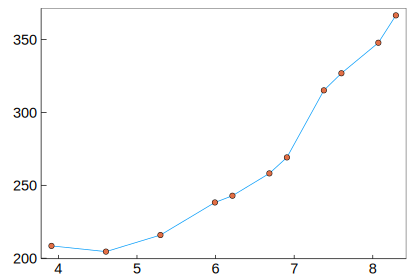

In [336]:
plot(log.(numpoints), log.(valuesIPRneg[:,1]), seriestype = [:line, :scatter],
    legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))

In [638]:
fitAll = curve_fit(linearmodel, log.(numpoints[1:end]),log.(valuesIPRneg[:,1][1:end]), [0.5,0.1])
fittail = curve_fit(linearmodel, log.(numpoints[5:end]), log.(valuesIPRneg[:,1])[5:end], [0.5,0.1])
sigma_all = standard_error(fitAll)
sigma_tail = standard_error(fittail)
covar = estimate_covar(fitAll)
covartail = estimate_covar(fittail)
sigmaT = sqrt.(sigma_all[1].^2 .+ x_all.^2*sigma_all[2].^2 .+ 2*x_all*covar[2,1])
sigmaTail = sqrt.(sigma_tail[1].^2 .+ x_tail.^2*sigma_tail[2].^2 .+ 2*x_tail*covartail[2,1]);

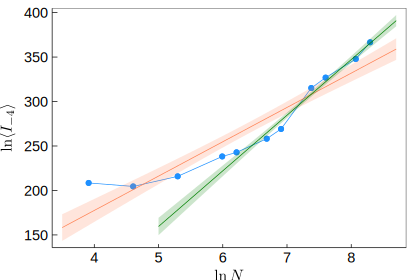

In [639]:
plot(log.(numpoints), log.(valuesIPRneg[:,1]), seriestype = [:scatter, :line], linecolor = :dodgerblue,
    m =(5, :dodgerblue, stroke(0)),
    legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"\ln N", ylab = L"\ln \langle I_{-4}\rangle", guidefont= font(15, "sans-serif"),
    dpi=70, size = (600,400))
plot!(x_all, linearmodel(x_all, fitAll.param), ribbon=(sigmaT, sigmaT), fillalpha=0.2, c = :coral)
plot!(x_tail, linearmodel(x_tail, fittail.param), ribbon=(sigmaTail, sigmaTail), fillalpha=0.2,
    c = :green)
#savefig("iprqm4.pdf")

In [640]:
fitAll.param

2-element Array{Float64,1}:
 23.14433952970663
 38.6039369458404 

In [641]:
fittail.param

2-element Array{Float64,1}:
 -153.25287889586087
   62.55025157943576

In [642]:
sigma_all

2-element Array{Float64,1}:
 30.443455675410398
  4.619980194607714

In [643]:
sigma_tail

2-element Array{Float64,1}:
 29.752085736608038
  4.053261299699268

In [644]:
covar

2×2 Array{Float64,2}:
  926.804  -137.685 
 -137.685    21.3442

In [645]:
covartail

2×2 Array{Float64,2}:
  885.187  -120.05  
 -120.05     16.4289

In [340]:
slopesNeg = zeros(40)
sigmasNeg = zeros(40)
for (indx, i) in enumerate(1:40)
    fittails = curve_fit(linearmodel, log.(numpoints[5:end]),log.(valuesIPRneg[:,i][5:end]), [0.5,0.1])
    slopesNeg[indx] = fittails.param[2]
    sigmasNeg[indx] =  standard_error(fittails)[2]
end

In [465]:
alphaqNeg = 1.0./(1 .- collect(-4:0.1:-0.1));

In [466]:
DqNeg = alphaqNeg.*slopesNeg;

In [467]:
sigNeg = sqrt.(alphaqNeg.^2.0.*sigmasNeg.^2);

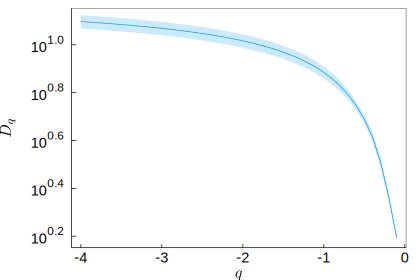

In [470]:
plot(collect(-4:0.1:-0.1), DqNeg, yscale = :log10, ribbon=(sigNeg, sigNeg), fillalpha=0.2,
    legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"q", ylab = L"D_q", guidefont= font(15, "sans-serif"),
    dpi=70, size = (600,400))
#plot!(collect(-4:0.1:-0.1), DqNeg, ribbon =(sigNeg, sigNeg))

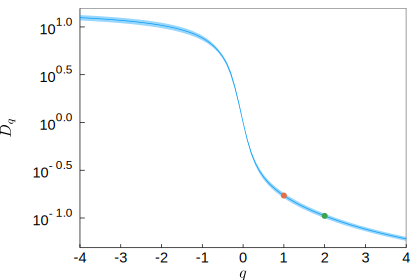

In [632]:
plot(collect(-4:0.1:4), vcat(DqNeg, Dq), yscale = :log10,
    xlim =(-4.0,4.0), xticks = ([-4,-3,-2,-1,0,1,2,3,4], [-4,-3,-2,-1,0,1,2,3,4]), 
    yformatter = :plain,
    ribbon=(vcat(sigNeg, sigma_err), vcat(sigNeg, sigma_err)), fillalpha=0.4,
    legend = false, grid = false, axis = :on, framestyle=:box,
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    xlab = L"q", ylab = L"D_q", guidefont= font(15, "sans-serif"),
    dpi=70, size = (600,400))
plot!([collect(-4:0.1:4)[51]], [vcat(DqNeg, Dq)[51]], m = (5, stroke(0)))
plot!([collect(-4:0.1:4)[61]], [vcat(DqNeg, Dq)[61]], m = (5, stroke(0)))
#savefig("fractalDbeta1.pdf")

In [615]:
collect(-4:0.1:4)[51]

1.0